# Análise de Desempenho de Site

## Importando as bibliotecas e carregando os dados

In [ ]:
# ! pip install statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
data = pd.read_csv("data-export.csv")

In [4]:
data.head()

,# ----------------------------------------,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Session primary channel group (Default channel...,Date + hour (YYYYMMDDHH),Users,Sessions,Engaged sessions,Average engagement time per session,Engaged sessions per user,Events per session,Engagement rate,Event count
1,Direct,2024041623,237,300,144,47.526666666666700,0.6075949367088610,4.673333333333330,0.48,1402
2,Organic Social,2024041719,208,267,132,32.09737827715360,0.6346153846153850,4.295880149812730,0.4943820224719100,1147
3,Direct,2024041723,188,233,115,39.93991416309010,0.6117021276595740,4.587982832618030,0.49356223175965700,1069
4,Organic Social,2024041718,187,256,125,32.16015625,0.6684491978609630,4.078125,0.48828125,1044


## Análise Exploratória dos Dados

In [5]:
new_header = data.iloc[0]  # pegue a primeira linha para cabeçalho
data = data[1:]  # pegue os dados menos a linha do cabeçalho
data.columns = new_header  # definir o novo cabeçalho para o dataframe
data.reset_index(drop=True, inplace=True)

In [6]:
data.head()

,Session primary channel group (Default channel group),Date + hour (YYYYMMDDHH),Users,Sessions,Engaged sessions,Average engagement time per session,Engaged sessions per user,Events per session,Engagement rate,Event count
0,Direct,2024041623,237,300,144,47.526666666666700,0.6075949367088610,4.673333333333330,0.48,1402
1,Organic Social,2024041719,208,267,132,32.09737827715360,0.6346153846153850,4.295880149812730,0.4943820224719100,1147
2,Direct,2024041723,188,233,115,39.93991416309010,0.6117021276595740,4.587982832618030,0.49356223175965700,1069
3,Organic Social,2024041718,187,256,125,32.16015625,0.6684491978609630,4.078125,0.48828125,1044
4,Organic Social,2024041720,175,221,112,46.918552036199100,0.64,4.529411764705880,0.5067873303167420,1001


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 10 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Session primary channel group (Default channel group)  3182 non-null   object
 1   Date + hour (YYYYMMDDHH)                               3182 non-null   object
 2   Users                                                  3182 non-null   object
 3   Sessions                                               3182 non-null   object
 4   Engaged sessions                                       3182 non-null   object
 5   Average engagement time per session                    3182 non-null   object
 6   Engaged sessions per user                              3182 non-null   object
 7   Events per session                                     3182 non-null   object
 8   Engagement rate                                        318

In [8]:
data.describe()

,Session primary channel group (Default channel group),Date + hour (YYYYMMDDHH),Users,Sessions,Engaged sessions,Average engagement time per session,Engaged sessions per user,Events per session,Engagement rate,Event count
count,3182,3182,3182,3182,3182,3182,3182,3182,3182,3182
unique,7,672,147,180,103,2823,808,2025,986,678
top,Direct,2024042417,1,1,0,0,0,1,0,1
freq,672,6,335,340,393,170,393,133,393,115


Vamos converter a coluna de data em um formato de data e hora apropriado e agrupá-la para análise posterior.

In [9]:
data["Date + hour (YYYYMMDDHH)"] = pd.to_datetime(
    data["Date + hour (YYYYMMDDHH)"], format="%Y%m%d%H"
)

In [10]:
data['Users'] = data['Users'].astype(int)
data['Sessions'] = data['Sessions'].astype(int)
data['Engaged sessions'] = data['Engaged sessions'].astype(int)
data['Event count'] = data['Event count'].astype(int)

In [11]:
data['Average engagement time per session'] = data['Average engagement time per session'].astype(float)
data['Engagement rate'] = data['Engagement rate'].astype(float)
data['Engaged sessions per user'] = data['Engaged sessions per user'].astype(float)
data['Events per session'] = data['Events per session'].astype(float)

In [12]:
data.dtypes

0
Session primary channel group (Default channel group)            object
Date + hour (YYYYMMDDHH)                                 datetime64[ns]
Users                                                             int32
Sessions                                                          int32
Engaged sessions                                                  int32
Average engagement time per session                             float64
Engaged sessions per user                                       float64
Events per session                                              float64
Engagement rate                                                 float64
Event count                                                       int32
dtype: object

In [13]:
# agrupar dados por data e somar os usuários e sessões
dados_agrupados = data.groupby( data['Date + hour (YYYYMMDDHH)']).agg({'Users': 'sum', 'Sessions': 'sum'})

O objetivo geral da operação acima é preparar e resumir o conjunto de dados para análise de série temporal, concentrando-se em como o envolvimento do usuário (por meio de sessões) varia de acordo com o tempo.  Ao converter dados em tipos apropriados e agrupá-los por tempo, você pode executar operações com mais facilidade, como traçar gráficos de séries temporais, calcular médias móveis ou aplicar modelos de previsão de séries temporais.

## Analisar o total de usuários e sessões ao longo do tempo

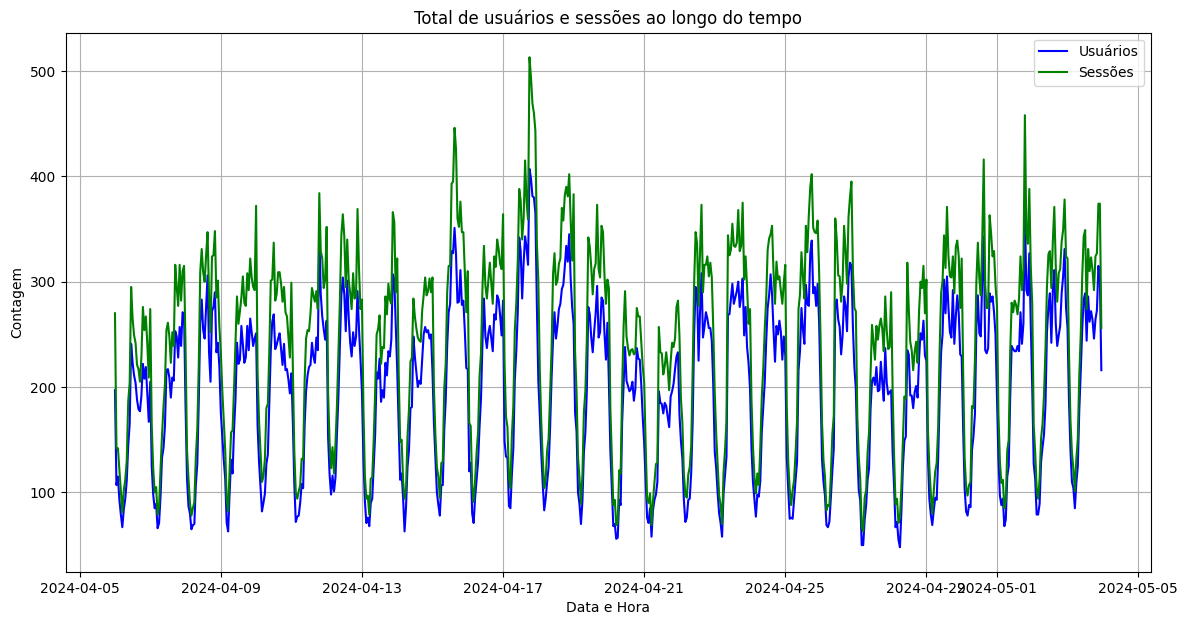

In [14]:
# plotando os usuários e sessões agregados ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dados_agrupados.index, dados_agrupados['Users'], label='Usuários', color='blue')
plt.plot(dados_agrupados.index, dados_agrupados['Sessions'], label='Sessões', color='green')
plt.title('Total de usuários e sessões ao longo do tempo')
plt.xlabel('Data e Hora')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.show()

No gráfico podemos observar que existem algumas oscilações no número de usuários e sessões, possivelmente indicando ciclos diários ou períodos específicos de alto tráfego. Tanto os usuários como as sessões parecem seguir uma tendência semelhante, o que é esperado, uma vez que mais usuários geralmente significam mais sessões. Alguns picos podem corresponder a atividades, promoções ou eventos de marketing específicos.

## Análise de envolvimento do usuário

In [15]:
# agrupar dados por data e calcular a média para métricas de engajamento
metricas_engajamento = data.groupby(data['Date + hour (YYYYMMDDHH)']).agg({
    'Average engagement time per session': 'mean',
    'Engaged sessions per user': 'mean',
    'Events per session': 'mean',
    'Engagement rate': 'mean'
})

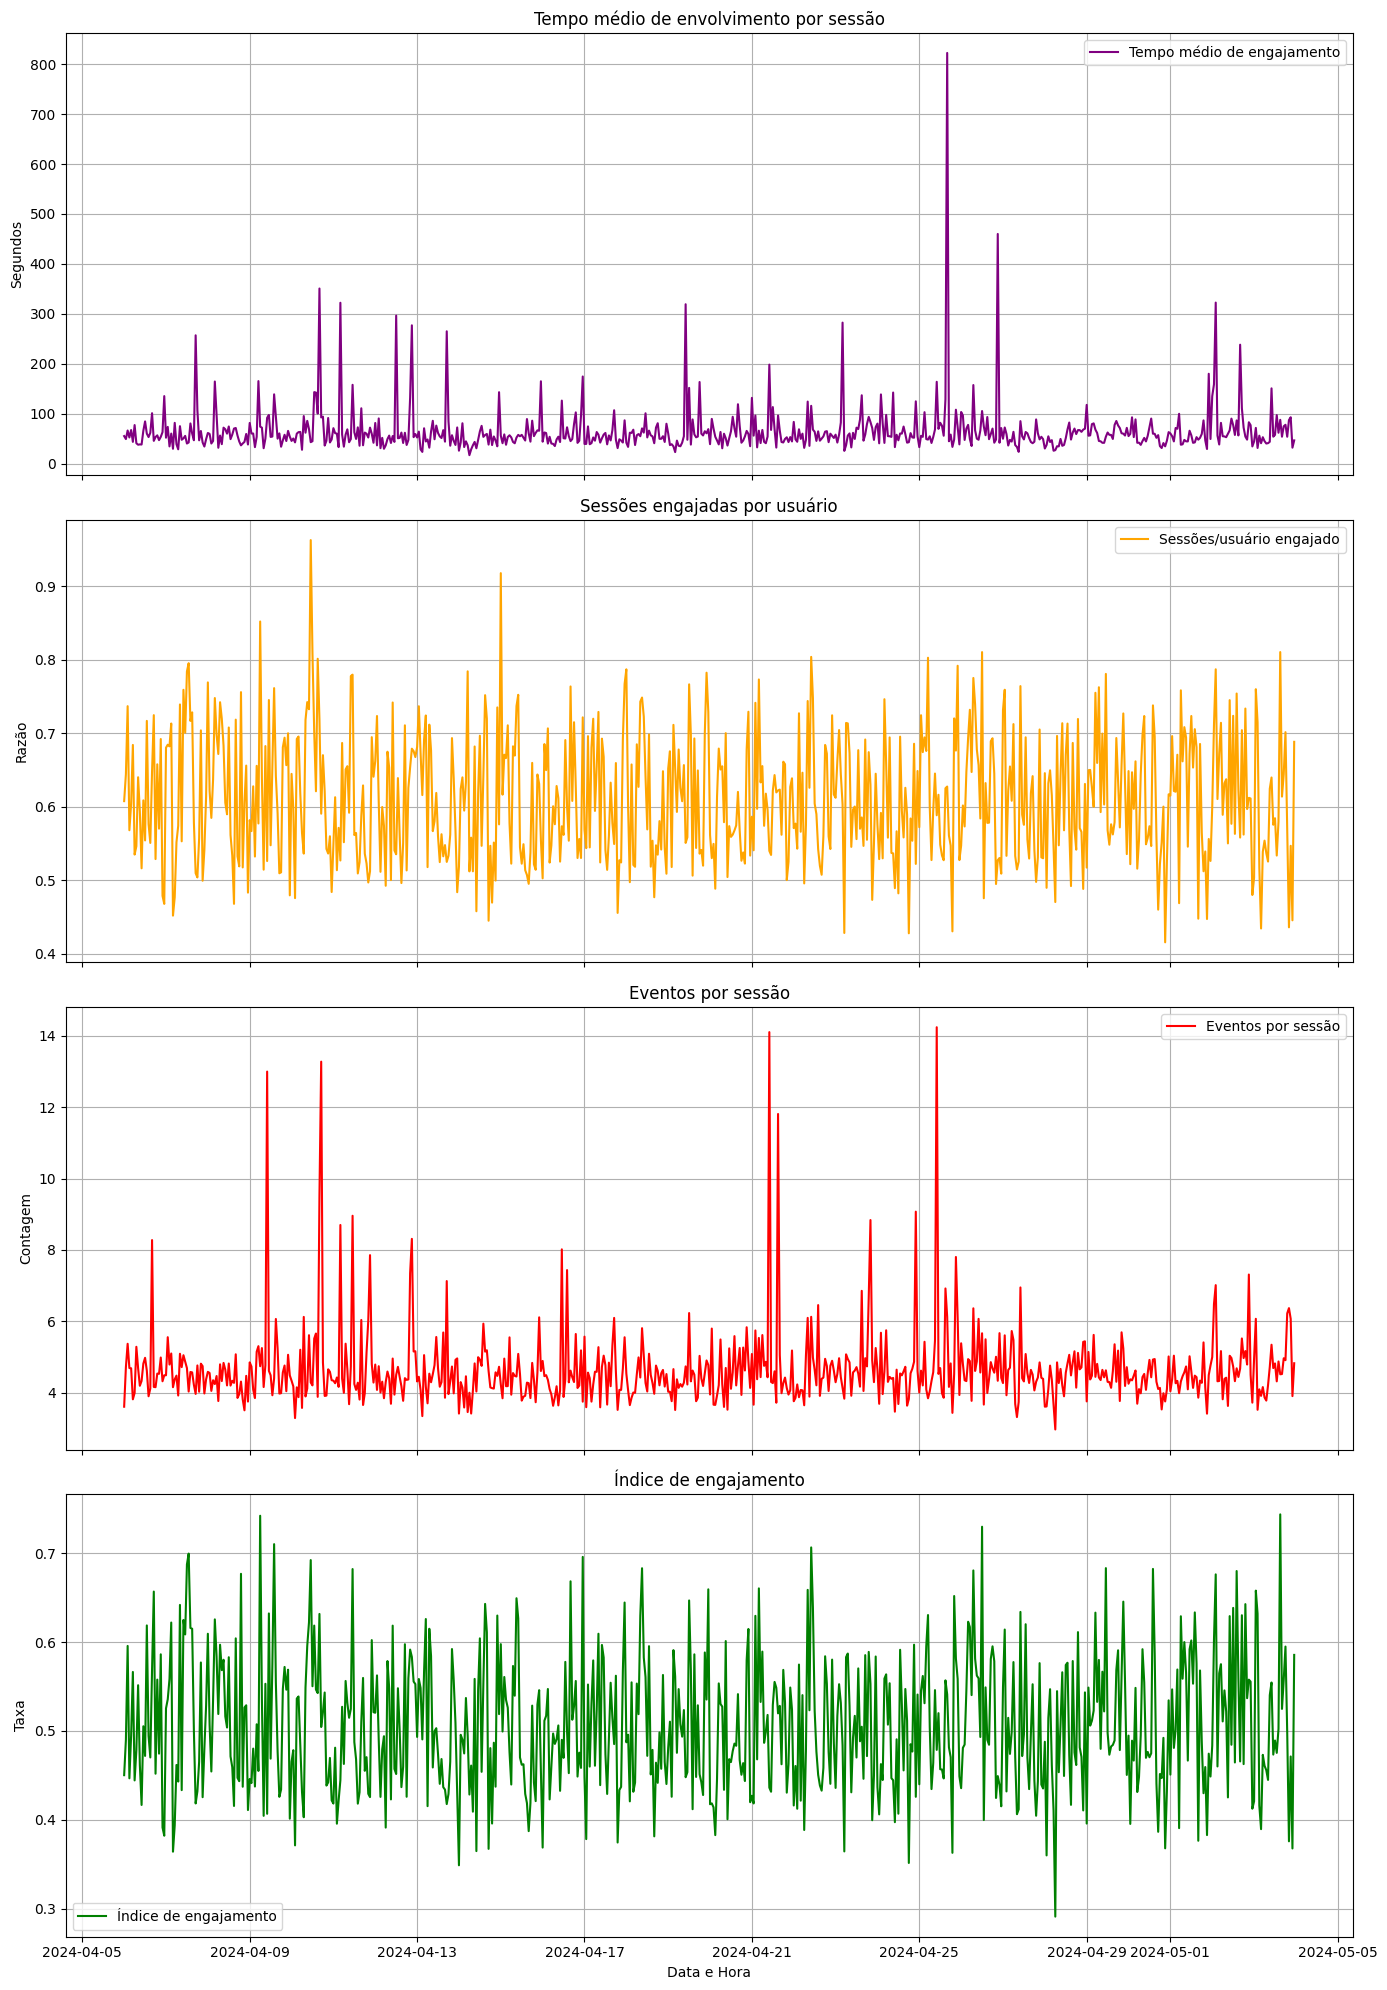

In [16]:
# plotando métricas de engajamento
fig, ax = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

ax[0].plot(metricas_engajamento.index, metricas_engajamento['Average engagement time per session'],
           label='Tempo médio de engajamento', color='purple')
ax[0].set_title('Tempo médio de envolvimento por sessão')
ax[0].set_ylabel('Segundos')

ax[1].plot(metricas_engajamento.index, metricas_engajamento['Engaged sessions per user'],
           label='Sessões/usuário engajado', color='orange')
ax[1].set_title('Sessões engajadas por usuário')
ax[1].set_ylabel('Razão')

ax[2].plot(metricas_engajamento.index, metricas_engajamento['Events per session'], label='Eventos por sessão',
           color='red')
ax[2].set_title('Eventos por sessão')
ax[2].set_ylabel('Contagem')

ax[3].plot(metricas_engajamento.index, metricas_engajamento['Engagement rate'], label='Índice de engajamento',
           color='green')
ax[3].set_title('Índice de engajamento')
ax[3].set_ylabel('Taxa')
ax[3].set_xlabel('Data e Hora')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

## Análise de Correlação

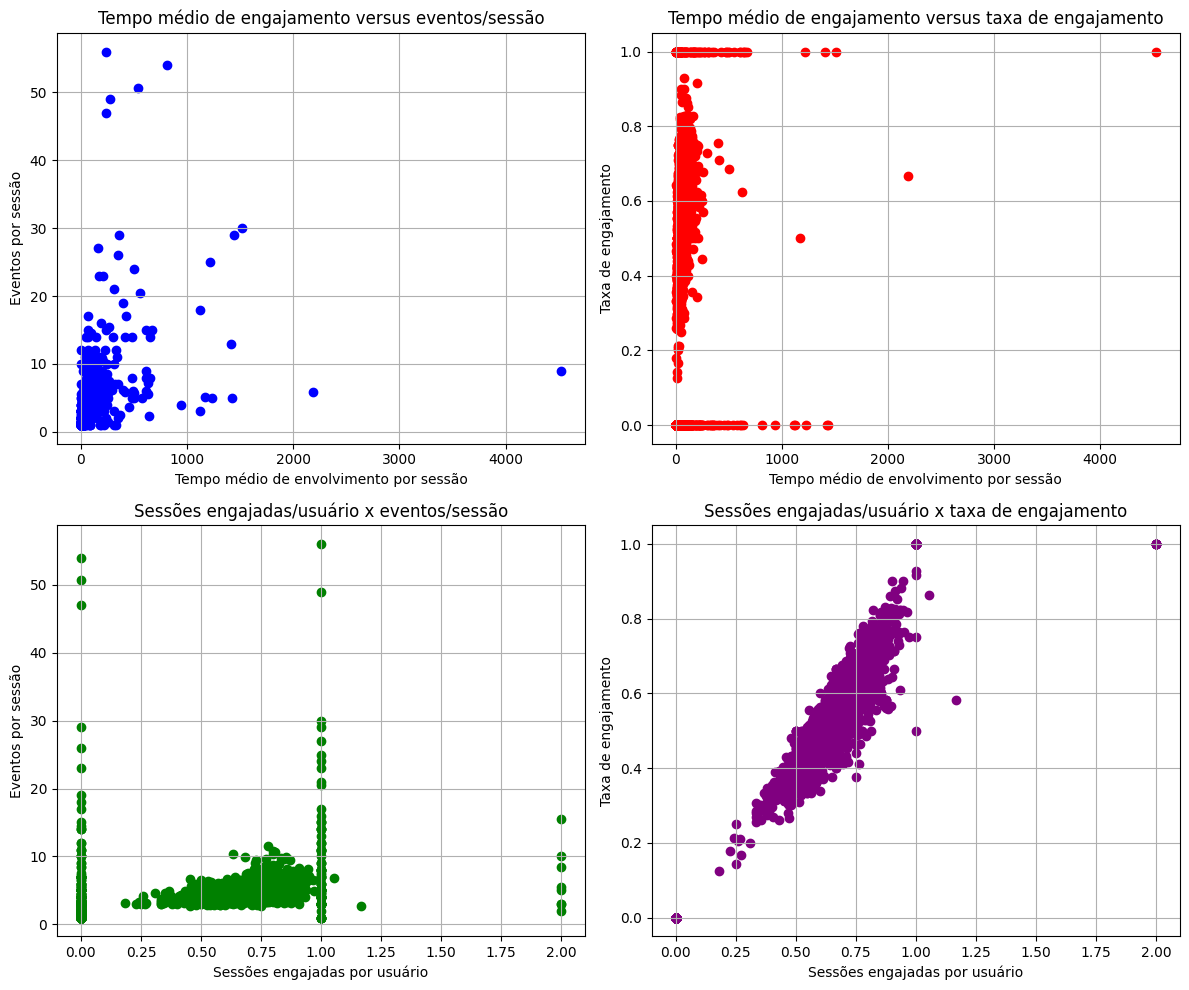

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# plot 1: tempo médio de engajamento versus eventos por sessão
axes[0, 0].scatter(data['Average engagement time per session'], data['Events per session'], color='blue')
axes[0, 0].set_title('Tempo médio de engajamento versus eventos/sessão')
axes[0, 0].set_xlabel('Tempo médio de envolvimento por sessão')
axes[0, 0].set_ylabel('Eventos por sessão')
axes[0, 0].grid(True)  # habilitar grade

# plot 2: tempo médio de engajamento versus taxa de engajamento
axes[0, 1].scatter(data['Average engagement time per session'], data['Engagement rate'], color='red')
axes[0, 1].set_title('Tempo médio de engajamento versus taxa de engajamento')
axes[0, 1].set_xlabel('Tempo médio de envolvimento por sessão')
axes[0, 1].set_ylabel('Taxa de engajamento')
axes[0, 1].grid(True)

# plot 3: sessões engajadas por usuário versus eventos por sessão
axes[1, 0].scatter(data['Engaged sessions per user'], data['Events per session'], color='green')
axes[1, 0].set_title('Sessões engajadas/usuário x eventos/sessão')
axes[1, 0].set_xlabel('Sessões engajadas por usuário')
axes[1, 0].set_ylabel('Eventos por sessão')
axes[1, 0].grid(True)

# plot 4: sessões engajadas por usuário versus taxa de engajamento
axes[1, 1].scatter(data['Engaged sessions per user'], data['Engagement rate'], color='purple')
axes[1, 1].set_title('Sessões engajadas/usuário x taxa de engajamento')
axes[1, 1].set_xlabel('Sessões engajadas por usuário')
axes[1, 1].set_ylabel('Taxa de engajamento')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Análise de Desempenho do Canal

In [18]:
# agrupar dados por canal e agregar métricas necessárias
desempenho_canal = data.groupby('Session primary channel group (Default channel group)').agg({
    'Users': 'sum',
    'Sessions': 'sum',
    'Engaged sessions': 'sum',
    'Engagement rate': 'mean',
    'Events per session': 'mean'
})

In [19]:
# normalizar a taxa de engajamento e eventos por sessão para comparação
desempenho_canal['Normalized Engagement Rate'] = desempenho_canal['Engagement rate'] / desempenho_canal['Engagement rate'].max()
desempenho_canal['Normalized Events per Session'] = desempenho_canal['Events per session'] / desempenho_canal['Events per session'].max()

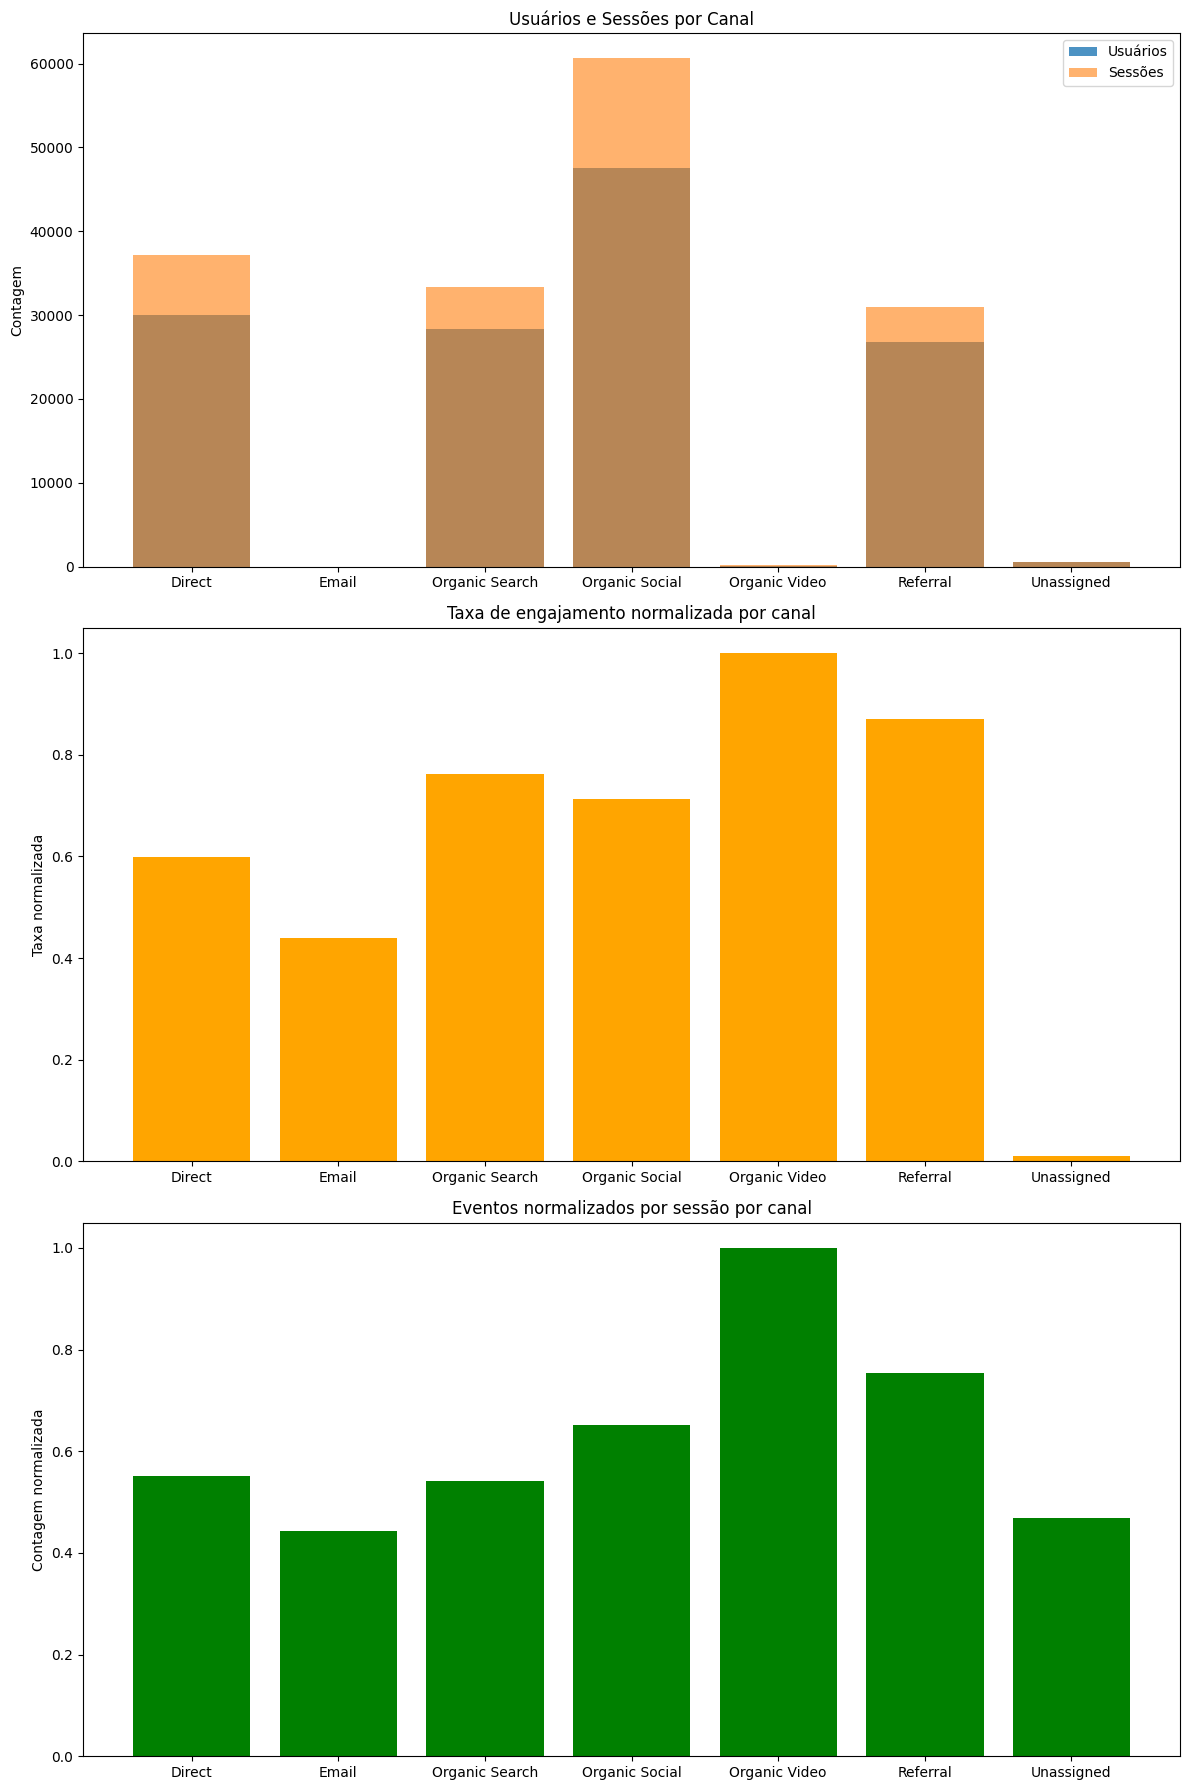

In [22]:
# traçando métricas de desempenho do canal
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# usuários e sessões por canal
ax[0].bar(desempenho_canal.index, desempenho_canal['Users'], label='Usuários', alpha=0.8)
ax[0].bar(desempenho_canal.index, desempenho_canal['Sessions'], label='Sessões', alpha=0.6)
ax[0].set_title('Usuários e Sessões por Canal')
ax[0].set_ylabel('Contagem')
ax[0].legend()

# taxa de engajamento normalizada por canal
ax[1].bar(desempenho_canal.index, desempenho_canal['Normalized Engagement Rate'], color='orange')
ax[1].set_title('Taxa de engajamento normalizada por canal')
ax[1].set_ylabel('Taxa normalizada')

# eventos normalizados por sessão por canal
ax[2].bar(desempenho_canal.index, desempenho_canal['Normalized Events per Session'], color='green')
ax[2].set_title('Eventos normalizados por sessão por canal')
ax[2].set_ylabel('Contagem normalizada')

plt.tight_layout()
plt.show()

## Previsão de tráfego do site

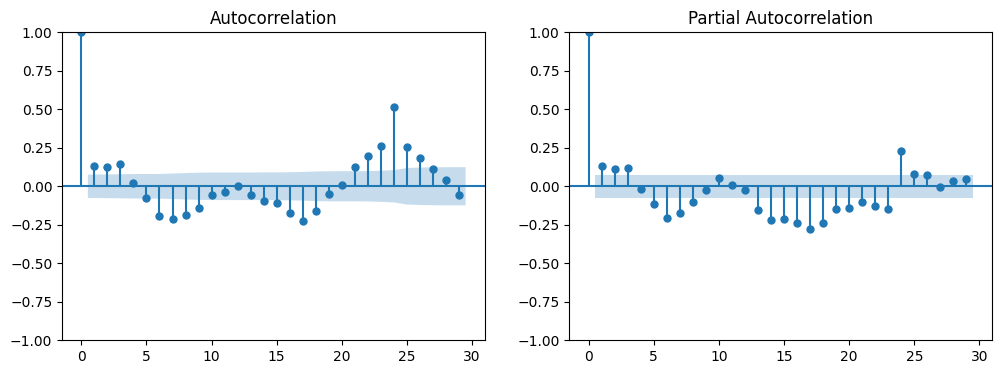

In [24]:
time_series_data = dados_agrupados['Sessions'].asfreq('H').ffill()
seasonal_period = 24

differenced_series = time_series_data.diff().dropna()

# traçar ACF e PACF de séries temporais
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [25]:
time_series_data = dados_agrupados['Sessions'].asfreq('H').ffill()
seasonal_period = 24


sarima_model = SARIMAX(time_series_data,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, seasonal_period))
sarima_model_fit = sarima_model.fit()

In [26]:
# prever as próximas 24 horas usando o modelo SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=24)

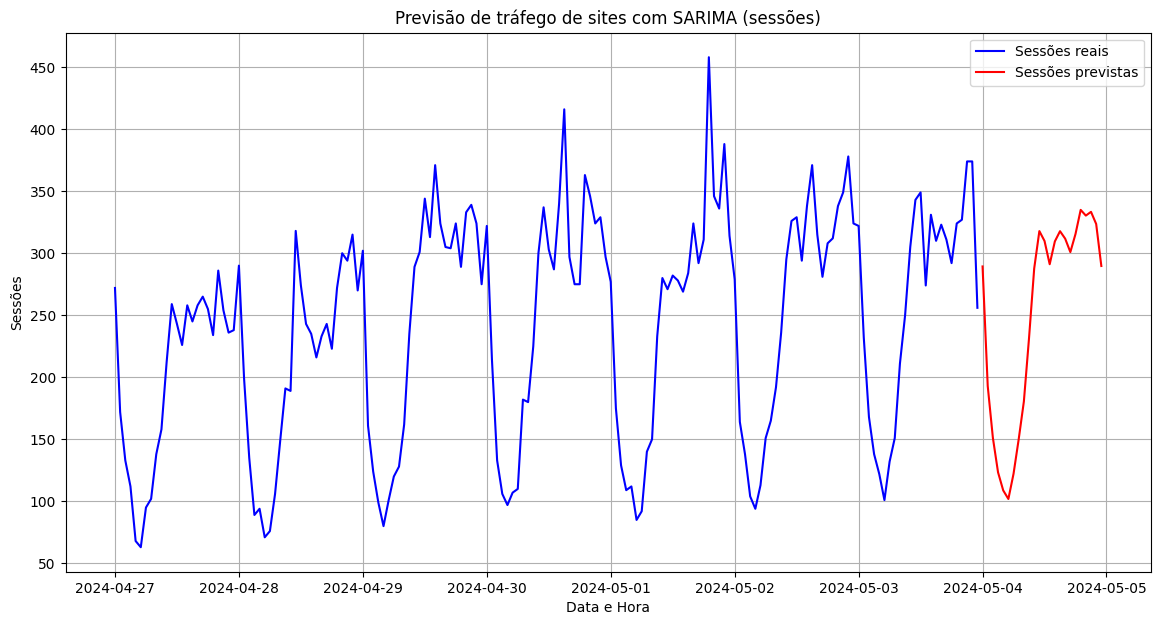

In [28]:
# plotando os dados reais e a previsão SARIMA
plt.figure(figsize=(14, 7))
plt.plot(time_series_data.index[-168:], time_series_data[-168:], label='Sessões reais', color='blue')  # dados da última semana
plt.plot(pd.date_range(time_series_data.index[-1], periods=25, freq='H')[1:], sarima_forecast, label='Sessões previstas', color='red')
plt.title('Previsão de tráfego de sites com SARIMA (sessões)')
plt.xlabel('Data e Hora')
plt.ylabel('Sessões')
plt.legend()
plt.grid(True)
plt.show()